In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtest import backtest, display_backtest_results

import warnings
warnings.filterwarnings("ignore")

start_date = "2010-01-01"
end_date = "2020-01-01"

In [2]:
# Read the portfolio weights long-format produced by main_1_get_weight.ipynb
file_names = os.listdir('portfolio_weights')
file_names = [file for file in file_names if os.path.isfile(os.path.join('portfolio_weights', file))]
file_names_annual = [string for string in file_names if "annual" in string]
names_annual = [file_names_annual.replace('weight_annual_', '').replace('.csv', '') for file_names_annual in file_names_annual]

weights_annual = []
for file in file_names_annual:
    tmp_weight = pd.read_csv("portfolio_weights/" + file)
    tmp_weight["Date"] = pd.to_datetime(tmp_weight["Date"])
    weights_annual.append(tmp_weight)
    
weights_annual = {}
for i in range(len(file_names_annual)):
    file = file_names_annual[i]
    strategy_name = names_annual[i]
    tmp_weight = pd.read_csv("portfolio_weights/" + file)
    tmp_weight["Date"] = pd.to_datetime(tmp_weight["Date"])
    weights_annual[strategy_name] = tmp_weight

# Read the FF5 data
ff5_annual = pd.read_csv("data_clean/FF5_annual.csv", index_col=0).iloc[:,:-1] / 100
ff5_annual.index = pd.to_datetime(ff5_annual.index, format='%Y')
ff5_annual = ff5_annual[(ff5_annual.index >= start_date) & (ff5_annual.index < end_date)]

Mkt_RF = ff5_annual["Mkt_RF"]
SMB = ff5_annual["SMB"]
HML = ff5_annual["HML"]
RMW = ff5_annual["RMW"]
CMA = ff5_annual["CMA"]

In [3]:
unique_dates = weights_annual["sae3CNNlstm"]["Date"].unique()
tickers = ["AGG", "DBC", "VIX", "VTI"]

# Symbolic Regression

In [4]:
AGG = ((((((0.75528973 - Mkt_RF) - Mkt_RF) * Mkt_RF) * -2.64096) + (RMW / 0.48064393)) + (0.5782028 + SMB))
DBC = ((((Mkt_RF * ((-0.008375801 / SMB) + (HML / (-0.008375801 - 0.24041964)))) - -0.10228153) + CMA) / 1.0571132)
VIX = (-0.009205342 / (((-0.29511827 + CMA) + Mkt_RF) - ((SMB * 1.3917743) + 0.10031292)))
VTI = (0.19678046 / ((0.55597466 - SMB) + (((RMW * ((HML - CMA) / CMA)) + SMB) / 0.29991513)))
SR_weight_wide = pd.DataFrame({"AGG": AGG, "DBC": DBC, "VIX": VIX, "VTI": VTI})
SR_weight_wide = SR_weight_wide.divide(SR_weight_wide.sum(axis=1), axis=0) # normalize so that weight sums to 1

In [17]:
SR_weight_wide.divide(SR_weight_wide.sum(axis=1), axis=0)

,AGG,DBC,VIX,VTI
2010-01-01,0.588208,0.234953,0.043964,0.132875
2011-01-01,0.779220,0.114259,0.025102,0.081419
2012-01-01,0.222665,0.369130,0.066324,0.341882
2013-01-01,0.441929,0.098631,0.035187,0.424253
2014-01-01,0.511634,0.077248,0.064523,0.346595
2015-01-01,0.536285,0.026505,0.014762,0.422447
2016-01-01,0.629175,0.051724,-0.006145,0.325245
2017-01-01,0.297509,0.180704,0.055880,0.465907
2018-01-01,0.715834,0.076914,-0.002114,0.209366
2019-01-01,0.485222,0.115310,0.154272,0.245196


In [5]:
# Repeat each row and concatenate them
SR_daily_weights_wide = pd.DataFrame()
for _, row in SR_weight_wide.iterrows():
    SR_daily_weights_wide = SR_daily_weights_wide.append([row]*252, ignore_index=True)
SR_daily_weights_wide = SR_daily_weights_wide.iloc[:unique_dates.shape[0]]
SR_daily_weights_wide.index = unique_dates

# convert wide format to long format
SR_daily_weights_long = weights_annual["sae3CNNlstm"].copy()
for index, row in SR_daily_weights_long.iterrows():
    date = row['Date']
    ticker = row['Ticker']
    SR_daily_weights_long.at[index, 'Weight'] = SR_daily_weights_wide.at[date, ticker]

,Symbolic Regression,SAE_3CNN_LSTM
avg annualized ret,0.069745,0.068074
avg annualized std,0.046645,0.042589
sharpe ratio,1.495232,1.598409
adjusted sharpe ratio,0.534066,0.843870
skewness,0.925750,-0.174543
excess kurtosis,9.377094,3.997548
maximum drawdown,-0.043240,-0.065759
maximum drawdown length (days),308.000000,420.000000
VaR (95%),-0.004028,-0.003802
CVaR (95%),-0.005855,-0.006153


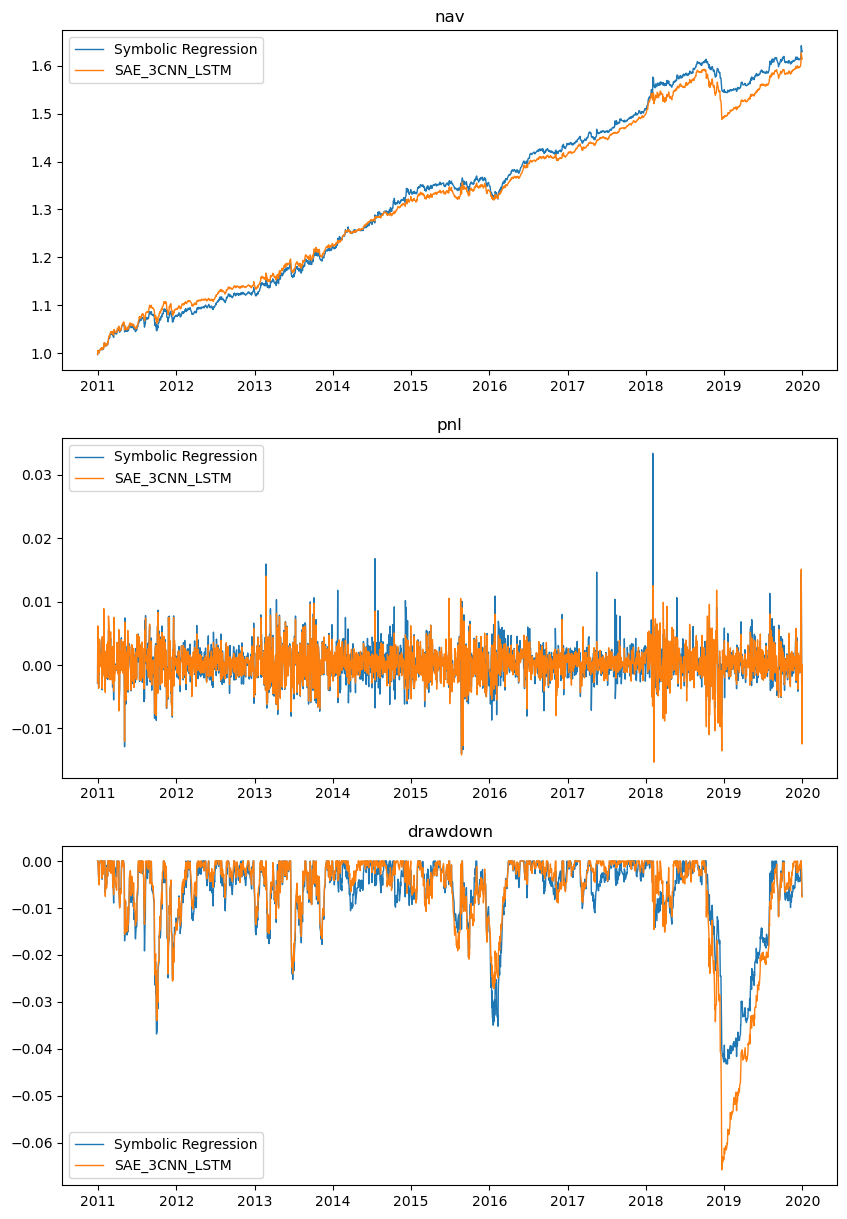

In [6]:
display_backtest_results([SR_daily_weights_long, weights_annual["sae3CNNlstm"]],
                         ["Symbolic Regression", "SAE_3CNN_LSTM"]
                        )

# Symbolic Regression (no division)

In [7]:
AGG = ((((0.6754607 - ((HML * -25.817741) * (SMB - CMA))) + SMB) - Mkt_RF) + RMW)
DBC = ((0.085083224 - (((CMA * 31.874401) - Mkt_RF) * RMW)) + CMA)
VIX = (((Mkt_RF + ((Mkt_RF - HML) + Mkt_RF)) - HML) * ((0.17106752 - SMB) + (CMA + -0.06438767)))
VTI = (0.3470881 - ((CMA - ((HML - RMW) - CMA)) * ((1.2123634 - SMB) - SMB)))
SR_weight_wide = pd.DataFrame({"AGG": AGG, "DBC": DBC, "VIX": VIX, "VTI": VTI})

In [8]:
# Repeat each row and concatenate them
SR_daily_weights_wide = pd.DataFrame()
for _, row in SR_weight_wide.iterrows():
    SR_daily_weights_wide = SR_daily_weights_wide.append([row]*252, ignore_index=True)
SR_daily_weights_wide = SR_daily_weights_wide.iloc[:unique_dates.shape[0]]
SR_daily_weights_wide.index = unique_dates

# convert wide format to long format
SR_daily_weights_long = weights_annual["sae3CNNlstm"].copy()
for index, row in SR_daily_weights_long.iterrows():
    date = row['Date']
    ticker = row['Ticker']
    SR_daily_weights_long.at[index, 'Weight'] = SR_daily_weights_wide.at[date, ticker]

,Symbolic Regression,SAE_3CNN_LSTM
avg annualized ret,0.080432,0.068074
avg annualized std,0.045542,0.042589
sharpe ratio,1.766105,1.598409
adjusted sharpe ratio,-1.697168,0.843870
skewness,1.501623,-0.174543
excess kurtosis,18.489575,3.997548
maximum drawdown,-0.042223,-0.065759
maximum drawdown length (days),235.000000,420.000000
VaR (95%),-0.004048,-0.003802
CVaR (95%),-0.005597,-0.006153


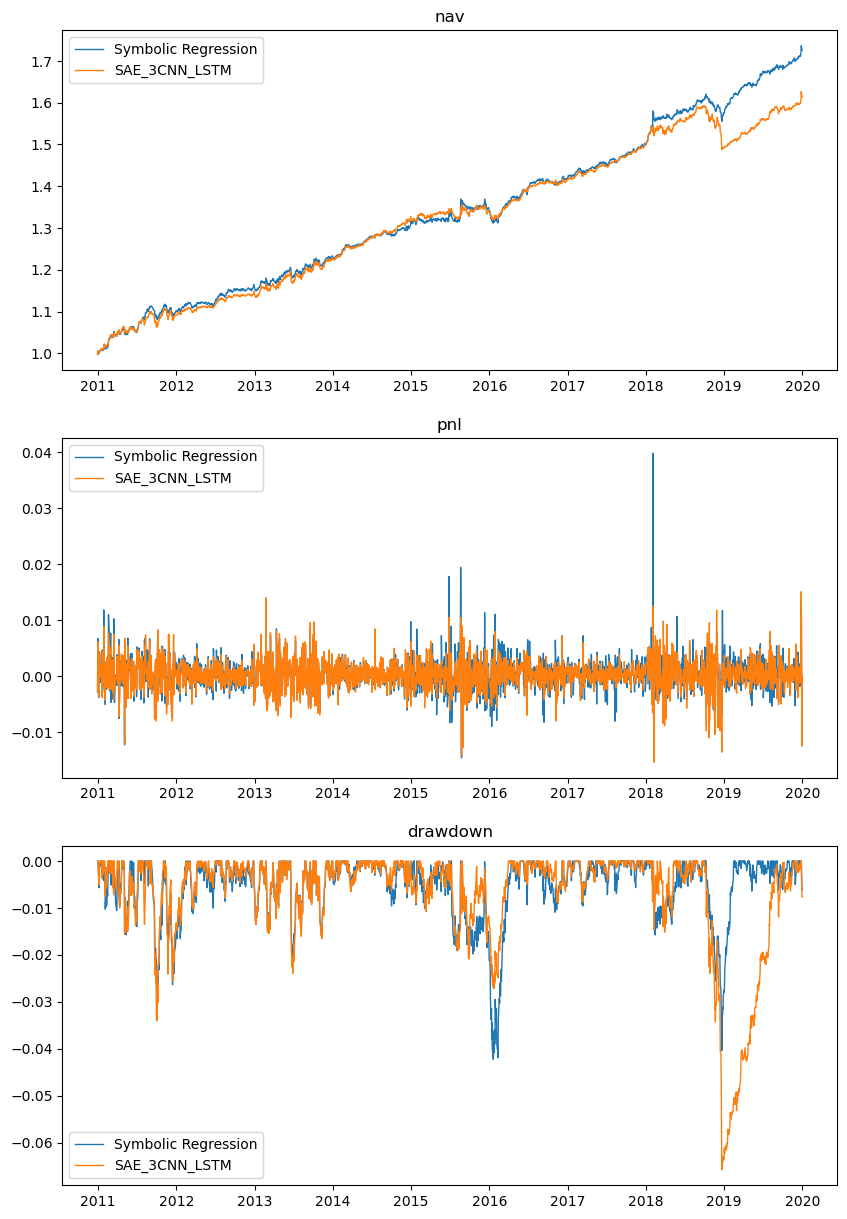

In [9]:
display_backtest_results([SR_daily_weights_long, weights_annual["sae3CNNlstm"]],
                         ["Symbolic Regression", "SAE_3CNN_LSTM"]
                        )